In [2]:
# %load_ext autoreload
# %autoreload 2
import pandas as pd
import numpy as np
from functools import wraps
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib.colors import TABLEAU_COLORS, CSS4_COLORS, to_rgb
from tqdm.auto import tqdm
import seaborn as sns
from datetime import datetime, timedelta
import math
import pickle
import warnings
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import mode, permutation_test, pearsonr, ttest_ind, ttest_1samp, wilcoxon, sem
from scipy.spatial import distance
from scipy import ndimage, interpolate
from pathlib import Path
import functools
import cv2
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['axes.grid'] = False
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['ytick.left'] = True
mpl.rcParams["font.family"] = "Helvetica"
mpl.rc('axes',edgecolor='black')

In [9]:
SCREEN_Y_POS = {'reptilearn4': -4.3, 'msi-regev': 0.06}
COLORS = {
    'PV42': '#1f77b4',
    'PV43': '#17becf',
    'PV85': '#ff7f0e',
    'PV91': '#2ca02c',
    'PV80': '#d62728',
    'PV95': '#bcbd22',
    'PV97': '#9467bd',
    'PV88': '#8c564b',
    'PV99': '#e377c2',
    'PV148': '#90EE90',
    'PV163': '#7f7f7f',
}
SCREEN_PIX_CM = {'reptilearn4': 52.704/1920, 'msi-regev': 34.3/1920}
SCREEN_START_X = {'reptilearn4': 5.59, 'msi-regev': 3.2}
ANIMALS = ['PV91', 'PV163', 'PV80', 'PV42', 'PV99']

## Figure 2

In [8]:
with open('fig2.pkl', 'rb') as f:
    fig2_data = pickle.load(f)

### 2a

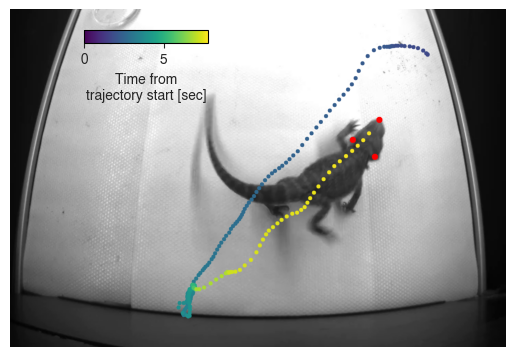

In [9]:
af = fig2_data['2a_pose_data']
frame = fig2_data['2a_frame']
af_ = af.dropna(subset=[('nose', 'cam_x')])['nose']
x = np.linspace(0, 1, len(af))
cmap = mpl.colormaps['viridis']
cmap_mat = (cmap(x)[:, :3] * 255).astype(int)
last_frame_id = af_.index[-2]
frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2RGB)
for i, row in af_.iloc[:-3].reset_index(drop=True).iterrows():
    color = cmap_mat[i, :].tolist()
    frame = cv2.circle(frame, (int(row.cam_x), int(row.cam_y)), 6, color, -1)

for bp in ['nose', 'left_ear', 'right_ear']:
    row = af[bp].loc[last_frame_id]
    if np.isnan(row.cam_x):
        continue
    frame = cv2.circle(frame, (int(row.cam_x), int(row.cam_y)), 9, (255, 0, 0), -1)

frame = frame[100:, :]
fig, ax = plt.subplots(1, 1)
ax.imshow(frame)
ax.grid(False)
ax.axis('off')
secs = (af.index.values - af.index[0]) / 60
cbaxes = ax.inset_axes([0.15, 0.9, 0.25, 0.04])
mpl.colorbar.ColorbarBase(cbaxes, cmap=cmap, norm=mpl.colors.Normalize(vmin=0, vmax=secs.max()), orientation='horizontal', label='Time from\ntrajectory start [sec]')

### 2b

In [ ]:
example_vids = [('top_20230625T093053', 'tab:purple'), ('top_20230624T090108', 'tab:green')]
fig, ax = plt.subplots(1,1)
max_hour = 16
rdf_ = rdf.loc[rdf.time.dt.hour <= max_hour].dropna()
# print(f'Number of sessions ')
h = sns.histplot(data=rdf_, x='x', y='y', bins=(25, 25), ax=ax, stat='probability', 
                 cmap=plt.cm.get_cmap('OrRd'),
                 cbar=False, cbar_kws=dict(shrink=.75, label='Probability'))
for vid_name, color in example_vids:
    rf = rdf.query(f'vid_name=="{vid_name}"').sort_values(by='frame_id')
    ax.plot(rf.x, rf.y, color=color, alpha=0.5)
ax.add_patch(Rectangle((0, 150), 50, 700, color='k'))
ax.text(0, (150+700)//2, 'screen', rotation=90, color='w', va='bottom', fontsize=14)
ax.axis('off')

### 2c

### 2d

## Figure 3

### 3d

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3))
sns.lineplot(data=df, x='time', y='y_pose', ax=ax, label='Lizard Y-Position [cm]')
sns.lineplot(data=df, x='time', y='y_traj', ax=ax, label='Bug Y-Position (screen) [cm]')
peaks, _ = find_peaks(-df.y_pose, height=-2, distance=20, width=8)
for t_ in df.time.iloc[peaks].values:
  plt.axvline(t_, linestyle='--', c='tab:red', alpha=0.6)
ax.set_ylabel('')
ax.set_xlabel('Time [sec]')
ax.legend()
ax.tick_params(bottom=True, left=True)

### 3e

Text(0.5, 0, 'Time before Strike [sec]')

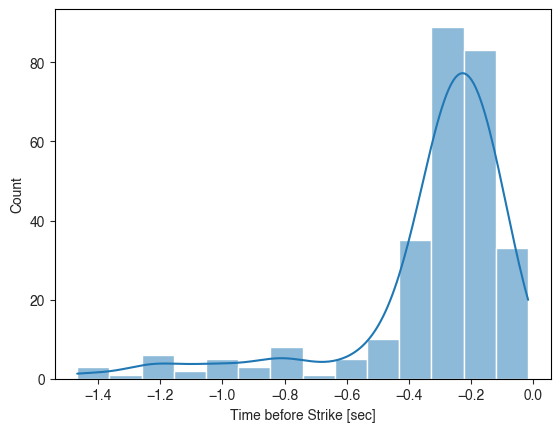

In [11]:
with open('3e.pkl', 'rb') as f:
    idx = pickle.load(f)
fig, ax = plt.subplots(1,1)
sns.histplot(x=list(idx.values()), kde=True, ax=ax, binwidth=0.1)
ax.tick_params(bottom=True, left=True)
ax.set_xlabel('Time before Strike [sec]')

### 3f + g

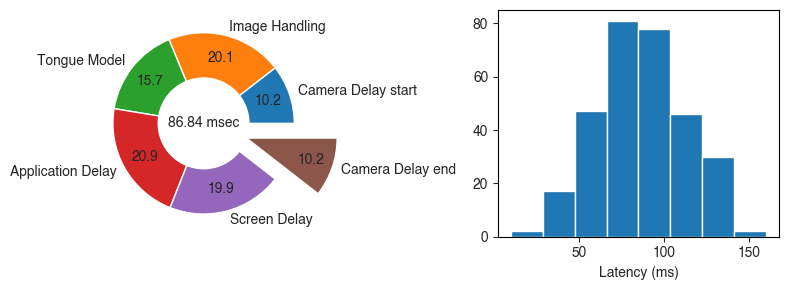

In [10]:
total_latency = 97.04
cam_delay = (10.2, 7)
latencies = {
    'Camera Delay start': cam_delay,
    'Image Handling': (20.1, 7),
    'Tongue Model': (15.7, 12),
    'Application Delay': (20.94, 13.49)
}
latencies['Screen Delay'] = (total_latency - sum([v[0] for v in latencies.values()]) - cam_delay[0], 0)
latencies['Camera Delay end'] = cam_delay
explode = (0, 0, 0, 0, 0, 0.5)
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes[0].pie([l[0] for l in latencies.values()], labels=list(latencies.keys()), autopct=lambda x: '{:.1f}'.format(x*total_latency/100), pctdistance=0.75, explode=explode)
my_circle = plt.Circle((0,0), 0.5, color='white')
axes[0].add_artist(my_circle)
axes[0].text(0, 0, f'{total_latency-cam_delay[0]} msec', horizontalalignment='center', verticalalignment='center')

with open('latency.pkl', 'rb') as f:
    d = pickle.load(f)
    data = d['data'] - cam_delay[0]
    
axes[1].hist(data, bins=8)
axes[1].set_xlabel('Latency (ms)')

fig.tight_layout()

## Figure 4

### 4c + 4d

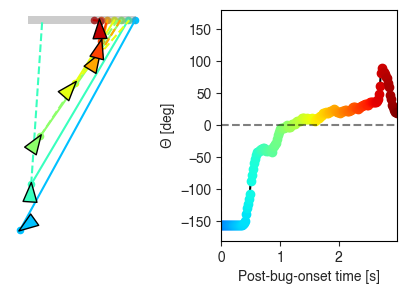

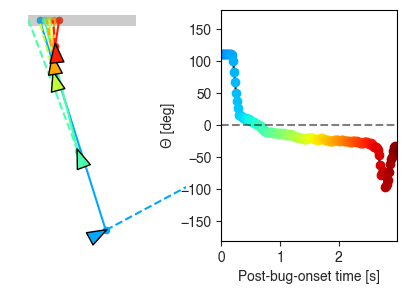

In [22]:
def calc_angle_between_lines(a1, b1, a2, b2):
    return np.arccos((a1*a2 + b1*b2) / (np.sqrt(a1**2 + b1**2) * np.sqrt(a2**2 + b2**2)))


def calc_gaze_deviation_angle(ang, bug_y, bug_x, x, y):
    m_exp = (y - bug_y) / (x - bug_x)
    if ang == np.pi/2:
        x_obs = x
        dev_ang = np.math.degrees(calc_angle_between_lines(1, 0, m_exp, -1))
    else:
        m_obs = np.tan(np.pi-ang)
        n_obs = y - m_obs*x
        x_obs = (bug_y - n_obs)/m_obs
        a = distance.euclidean((bug_x, bug_y), (x, y))
        b = distance.euclidean((x_obs, bug_y), (x, y))
        c = np.abs(x_obs - bug_x)
        dev_ang = np.arccos((a**2 + b**2 - c**2) / (2*a*b))
        if ang > np.pi:
            dev_ang = np.pi - dev_ang
        dev_ang = np.math.degrees(dev_ang)

    sgn = np.sign(x_obs - bug_x) if ang < np.pi else -np.sign(x_obs - bug_x)
    return sgn * dev_ang, x_obs


def plot_traj_with_bug(af, triangles_step=10, is_plot_frames=True, frames_step=10, bug_y=-4.3):
    fig, axes = plt.subplots(1, 2, figsize=(5, 3))
    arrow_len = 0.5
    cmap = cm.get_cmap('jet')
    z = np.linspace(0, 1, len(af))

    dev_angles, head_angles, bug_trajs = [], [], []
    frames_data = []
    for i, row in af.iterrows():
        if any(row[f'{bp}_prob'] < 0.8 for bp in ['nose', 'right_ear', 'left_ear']):
            continue
        x, y, bug_x, ang = row.nose_x, row.nose_y, row.bug_x_cm, row.angle
        if np.isnan(x) or np.isnan(y) or np.isnan(bug_x):
            continue
        color = cmap(z[i])
        dev_ang, x_obs = calc_gaze_deviation_angle(ang, bug_y, bug_x, x, y)
        dev_angles.append((row.total_sec, dev_ang))
        head_angles.append((row.total_sec, np.rad2deg(row.angle)))
        bug_trajs.append((row.total_sec, row.bug_y, row.bug_x_cm))
        
        axes[1].scatter(row.total_sec, dev_ang, color=color)

        if is_plot_frames and not (i % frames_step):
            row['dev_ang'] = dev_ang
            row['color'] = color
            frames_data.append(row)

        if i % triangles_step:
            continue

        axes[0].scatter(x, y, marker='o', s=20, color=color)
        axes[0].scatter(bug_x, bug_y, color=color, marker='o', s=20)
        if not np.isnan(bug_x):
            if ang < np.pi:
                axes[0].plot([x, x_obs], [y, bug_y], '--', color=color)
            axes[0].plot([x, bug_x], [y, bug_y], color=color)
        axes[0].annotate('', (x-arrow_len*np.cos(np.pi - ang), y-arrow_len*np.sin(np.pi - ang)), (x, y), 
                    arrowprops=dict(width=0.3, headwidth=10, headlength=14, shrink=.1, 
                                    facecolor=color, edgecolor='k'))

    for i, l in enumerate([dev_angles]):
      t = np.array([x[0] for x in l])
      a = np.array([x[1] for x in l])
      axes[i+1].plot(t, a, color='k', zorder=-1)
    
    axes[0].set_xlim([0, 70])
    axes[0].invert_yaxis()
    axes[0].add_patch(Rectangle((7, bug_y-1), 43, 2, linewidth=1, edgecolor='none', facecolor='grey', alpha=0.4))
    axes[0].axis('off')
    
    axes[1].axhline(0, color='k', linestyle='--', alpha=0.5)
    axes[1].axvline(0, color='k', linestyle='--', alpha=0.5)
    axes[1].set_ylim([-180, 180])
    
    for i in range(2):  
      axes[i].set_ylabel('Θ [deg]')
      axes[i].set_xlabel('Post-bug-onset time [s]')
      axes[i].margins(x=0)

plot_traj_with_bug(pd.read_csv('4c_1.csv', index_col=0), triangles_step=25)
plot_traj_with_bug(pd.read_csv('4c_2.csv', index_col=0), triangles_step=35)

### 4e

Text(0.5, 0, 'Post-bug-onset time [s]')

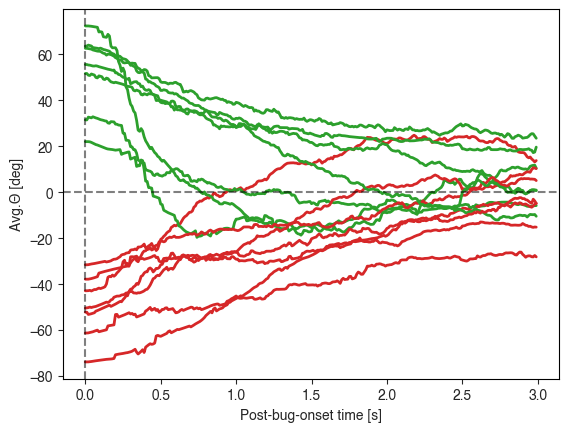

In [24]:
with open('4e.pkl', 'rb') as f:
    avgs = pickle.load(f)
    
ax  = plt.subplot()
for animal_id, d in avgs.items():
    ax.plot(*d['left'], color='tab:red', linewidth=2)
    ax.plot(*d['right'], color='tab:green', linewidth=2)
ax.axhline(0, color='k', linestyle='--', alpha=0.5)
ax.axvline(0, color='k', linestyle='--', alpha=0.5)
ax.set_ylabel('Avg.Θ [deg]')
ax.set_xlabel('Post-bug-onset time [s]')

### 4f

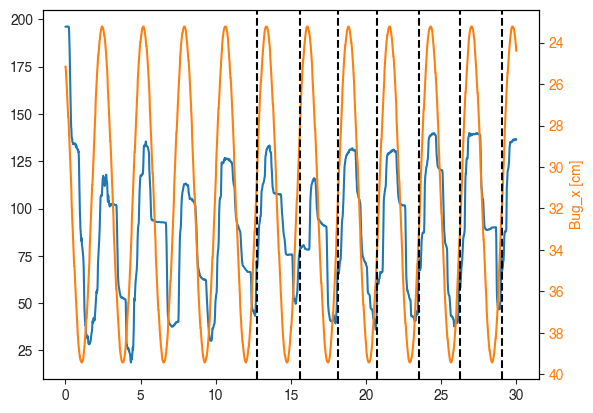

In [16]:
with open('4f.pkl', 'rb') as f:
    data = pickle.load(f)
    af, strikes_times = data['af'], data['strikes_times']
ax = plt.subplot()
ax.plot(af.total_sec, af.angle, label='Head angle')
ax2 = ax.twinx()
ax2.plot(af.total_sec, af.bug_x_cm, color='tab:orange', zorder=-1)
ax2.invert_yaxis()
ax2.set_ylabel('Bug_x [cm]', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')
for t in strikes_times:
  ax2.axvline(t, color='k', linestyle='--')

### 4g

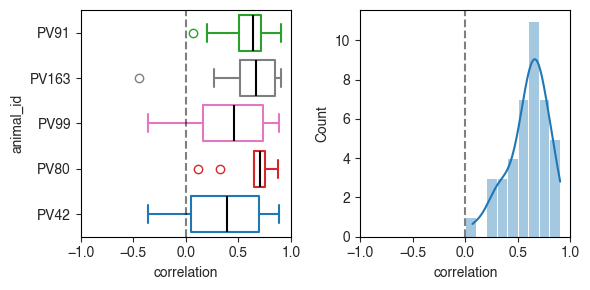

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
cf = pd.read_csv('4g.csv', index_col=0)
sns.boxplot(data=cf,  x='correlation', y='animal_id', hue='animal_id', legend=False, ax=axes[0], fill=False, medianprops={"color": "k"}, palette=COLORS)
axes[0].axvline(0, color='k', linestyle='--', alpha=0.5)
axes[0].set_xlim([-1, 1])

sns.histplot(data=cf.query('animal_id=="PV91"'), x='correlation', ax=axes[1], bins=np.arange(-1, 1, 0.1), kde=True, alpha=0.4)
axes[1].axvline(0, color='k', linestyle='--', alpha=0.5)
axes[1].set_xlim([-1, 1])

fig.tight_layout()

### 4h

## Figure 5

### 5a

/tmp/ipykernel_41083/1440688999.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=xf, x='proj_strike_x', y='animal_id', palette=COLORS, legend=False, ax=ax)


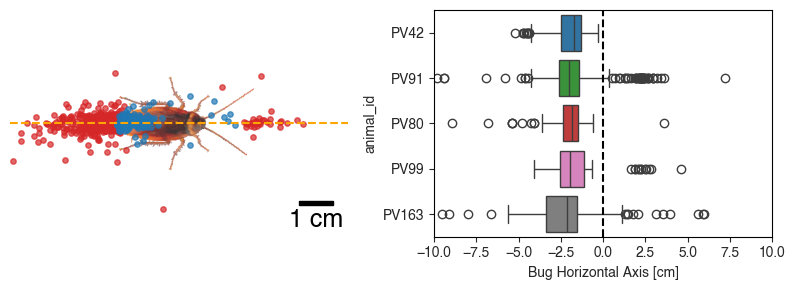

In [13]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

fontprops = fm.FontProperties(size=18)
screen_pix_cm_ratio = 52.704/1920
max_proj_x, max_proj_y = 180 * screen_pix_cm_ratio, 210 * screen_pix_cm_ratio

def plot_projected(ax, af):
    ax.axhline(0, linestyle='--', color='orange')
    for state, color in {0: 'tab:red', 1: 'tab:blue'}.items():
      af_ = af.query(f'is_hit=={state}')
      ax.scatter(af_.proj_strike_x, af_.proj_strike_y * screen_pix_cm_ratio, 
                 c=color, label='hit' if state else 'miss', s=15, alpha=0.7)
    ax.set_xlim([-max_proj_x, max_proj_x])
    ax.set_ylim([-max_proj_y, max_proj_y])
    
    im = cv2.imread('cockroach1.png', -1)
    im = ndimage.rotate(im, 270)
    im[np.where(im[:, :, 3] == 0)] = (255, 255, 255, 255)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    cax = ax.inset_axes(np.array([-70, -130, 150, 260])* screen_pix_cm_ratio, zorder=-1, transform=ax.transData)
    cax.imshow(im, aspect='auto', alpha=0.8)
    cax.axis('off')
    ax.axis('off')
    
    scalebar = AnchoredSizeBar(ax.transData,
                               1, '1 cm', 'lower right', 
                               pad=0.1,
                               color='k',
                               frameon=False,
                               size_vertical=0.2,
                               fontproperties=fontprops)

    ax.add_artist(scalebar)


def plot_strikes_box(ax, xf):
  sns.boxplot(data=xf, x='proj_strike_x', y='animal_id', palette=COLORS, legend=False, ax=ax)
  ax.set_xlim([-10, 10])
  ax.axvline(0, linestyle='--', color='k')
  ax.set_xlabel('Bug Horizontal Axis [cm]')
  
    
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
strikes_df = pd.read_csv('5a.csv', index_col=0)
plot_projected(axes[0], strikes_df.query('animal_id=="PV91"'))
plot_strikes_box(axes[1], strikes_df)
fig.tight_layout()

### 5b

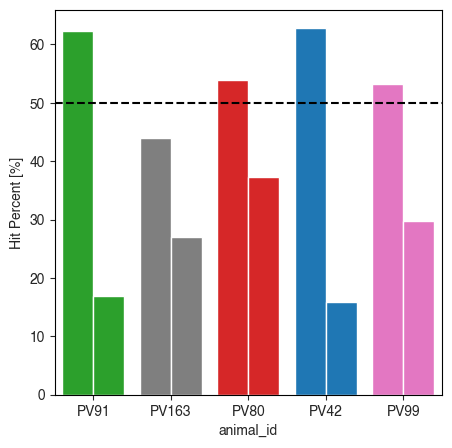

In [26]:
def hit_percent():
  x,y = 'animal_id', 'is_hit1'
  df1 = pd.read_csv('5b.csv', index_col=[0, 1, 2])
  df1 = df1.mul(100).reset_index()
  df1['color'] = df1.apply(lambda row: COLORS[row.animal_id], axis=1)
  
  fig, ax = plt.subplots(1, 1, figsize=(5, 5))
  sns.barplot(data=df1.query('is_hit'), x=x, y='percent',hue='movement_type', ax=ax, 
              order=ANIMALS, hue_order=["random_low_horizontal","circle"], legend=False)  # {False: 'grey', True: 'black'}
  ax.set_ylabel('Hit Percent [%]')
  ax.axhline(50, linestyle='--', color='k')
  for bar_group, desaturate_value in zip(ax.containers, [1, 1]):
      for bar, color in zip(bar_group, [COLORS[a] for a in ANIMALS]):
          bar.set_facecolor(sns.desaturate(color, desaturate_value))
  
  
hit_percent()

### 5c

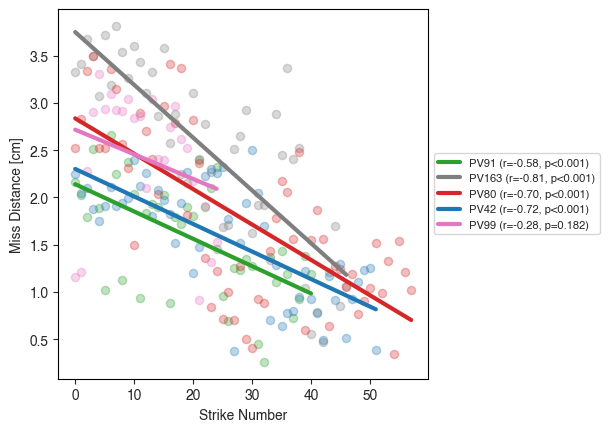

In [28]:
from scipy.stats import linregress

def plot_regression(ax, x, y, color='deeppink', prefix='', linewidth=2, is_legend=True, is_legend_outside=True,
                    is_plot=True, is_line_equation=False, legend_fontsize=8):
    assert isinstance(x, np.ndarray) and isinstance(y, np.ndarray), f'inputs must be numpy arrays'
    exclude_idx = np.concatenate([np.argwhere(np.isnan(x)), np.argwhere(np.isnan(y))])
    x, y = np.delete(x, exclude_idx), np.delete(y, exclude_idx)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    if is_plot:
        y_reg = slope * x + intercept
        p_val_text = f'p={p_value:.3f}' if p_value >= 0.001 else 'p<0.001'
        label = f'r={r_value:.2f}, {p_val_text}'
        if is_line_equation:
            label = label + f'\n(y={slope:.3f}x + {intercept:.3f})'
        if prefix:
            label = f'{prefix} ({label})'
        ax.plot(x, y_reg, color=color, label=label, linewidth=linewidth)
        if is_legend:
            if is_legend_outside:
                ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': legend_fontsize})
            else:
                ax.legend(prop={'size': legend_fontsize})
    return r_value, p_value


gf = pd.read_csv('5c.csv', index_col=0)
ax = plt.subplot()
for animal_id in ANIMALS:
    g2 = gf.query(f'animal_id=="{animal_id}"')
    x = np.arange(len(g2))
    res = g2.miss_distance.values
    # if animal_id == EXAMPLE_ANIMAL:
    sc = ax.scatter(x, res, color=COLORS[animal_id], alpha=0.3, s=35)
    plot_regression(ax, x, res, color=COLORS[animal_id], prefix=animal_id, linewidth=3)
    ax.set_ylabel('Miss Distance [cm]')
    ax.set_xlabel('Strike Number')
    ax.tick_params(bottom=True, left=True)
    ax.set_box_aspect(1)

### 5d

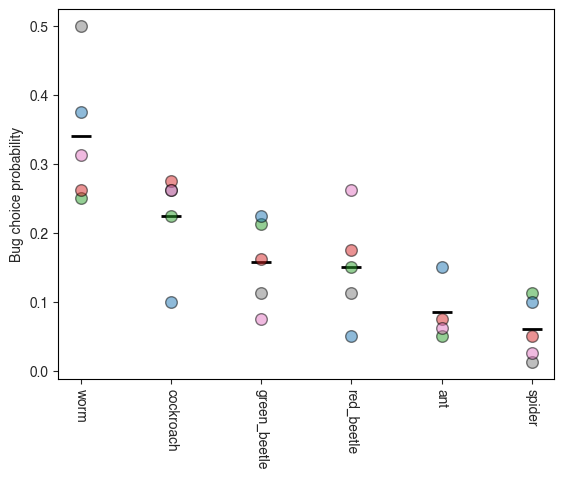

In [30]:
bugs_df = pd.read_csv('5d.csv', index_col=0)
avg = bugs_df.groupby('bug_type').val.mean().sort_values(ascending=False)
ax = plt.subplot()
ax.scatter(avg.index, avg.values, linewidth=2, color='black', label='Average', marker='_', s=200)
for animal_id in bugs_df.animal_id.unique():
  ax.scatter(avg.index, bugs_df.query(f'animal_id=="{animal_id}"').set_index('bug_type').val.reindex(avg.index), color=COLORS[animal_id], 
             label=animal_id, alpha=0.5, s=70, edgecolors='black')

ax.set_ylabel('Bug choice probability')
ax.tick_params(axis='x', labelrotation=270)